In [41]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision.transforms import ToTensor, Compose, Resize
from matplotlib import pyplot as plt

from PIL import Image

In [42]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [43]:
import os
dl = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        dl+=[os.path.join(dirname, filename)]
dl = dl[1:]

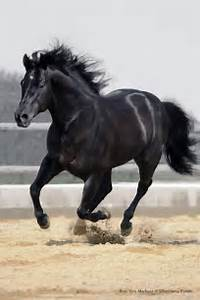

In [44]:
img = Image.open(dl[1])
img

In [70]:
class Animal10(Dataset):
    def __init__(self, input_list):
        self.transform = Compose([
            Resize((32,32),Image.BILINEAR), 
            ToTensor(),
        ])
        self.iml = input_list    
        self.translate = {"cane":0, "cavallo": 1, "elefante": 2, "farfalla":3, "gallina": 4, "gatto":5, "mucca":6, "pecora":7, "scoiattolo": 8, "ragno" : 9}
        
    def __len__(self):
        return len(self.iml)
        
    def __getitem__(self, idx):
        imp = self.iml[idx]
        img = Image.open(imp).convert('RGB')
        parts = imp.split('/')
        extracted_part = parts[-2]
        return self.transform(img),self.translate[extracted_part]
        

In [71]:
file_path = "/kaggle/input/animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg"

# Split the file path by slashes
parts = file_path.split('/')

# Extract the part between the last two slashes
extracted_part = parts[-2]

print(extracted_part)  # Output: cane

cane


In [72]:
batch_size=4096

trainDS = Animal10(dl)
train_dataloader=DataLoader(dataset=trainDS, batch_size=batch_size, shuffle=True)
eval_dataloader=DataLoader(dataset=trainDS, batch_size=batch_size, shuffle=True)

In [47]:
class Encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=1024,out_features=512)
        self.l2=nn.Linear(in_features=512,out_features=256)
    
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.lkrelu(net2)
        return out2
    
class Decoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.sig=nn.Sigmoid()
        self.l1=nn.Linear(in_features=256,out_features=512)
        self.l2=nn.Linear(in_features=512,out_features=1024)
    
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.sig(net2)
        return out2

class Encoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=256,out_features=100)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        return out1
    
class Decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=100,out_features=256)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        return out1

In [48]:
lossmse_fn=nn.MSELoss()
lossentropy_fn=nn.CrossEntropyLoss()
lr=0.001

e1=Encoder1().to(device)
d1=Decoder1().to(device)
e2=Encoder2().to(device)
d2=Decoder2().to(device)

opte1=Adam(params=e1.parameters(),lr=lr)
optd1=Adam(params=d1.parameters(),lr=lr)
opte2=Adam(params=e2.parameters(),lr=lr)
optd2=Adam(params=d2.parameters(),lr=lr)

In [65]:
# Train AutoEncoder1
def train_e1d1():    
    track_loss=0
    
    e1.train()
    d1.train()
    
    for i,(x,_) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,1024))
        x=x.to(device)

        latent=e1(x)
        pred=d1(latent)
            
        loss=lossmse_fn(pred,x)
        
        track_loss+=loss.item()
          
        loss.backward()
        
        opte1.step()
        optd1.step()
        
        opte1.zero_grad()
        optd1.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    return round(running_loss,4)

# Train AutoEncoder2
def train_e2d2():    
    track_loss=0
    
    e2.train()
    d2.train()
    
    for i,(x,_) in enumerate(train_dataloader):
        x=torch.reshape(x,shape=(-1,1024))
        x=x.to(device)

        latente1=e1(x)
        latente2=e2(latente1.detach())
        pred=d2(latente2)
            
        loss=lossmse_fn(pred,latente1.detach()) 
        
        track_loss+=loss.item()
        
        loss.backward()
        
        opte2.step()
        optd2.step()
        opte2.zero_grad()
        optd2.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4)

In [59]:
# Eval AutoEncoder1
def eval_e1d1():
    track_loss=0
    
    e1.eval()
    d1.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,1024))
            x=x.to(device)

            latent=e1(x)
            pred=d1(latent)

            loss=lossmse_fn(pred,x)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4),x,pred

# Eval AutoEncoder2
def eval_e2d2():
    track_loss=0
    
    e2.eval()
    d2.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(eval_dataloader):
            x=torch.reshape(x,shape=(-1,1024))
            x=x.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=d2(latente2)

            loss=lossmse_fn(pred,latente1)
            
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4)

-----------------------Auto Encoder 1------------------------
Epoch=1, Train Loss=0.0228, Eval Loss=0.0225
Epoch=2, Train Loss=0.0228, Eval Loss=0.0228
Epoch=3, Train Loss=0.0222, Eval Loss=0.0215
Epoch=4, Train Loss=0.0217, Eval Loss=0.0208
Epoch=5, Train Loss=0.0209, Eval Loss=0.021
Epoch=6, Train Loss=0.0206, Eval Loss=0.0203
Epoch=7, Train Loss=0.0201, Eval Loss=0.0215
Epoch=8, Train Loss=0.0204, Eval Loss=0.0194
Epoch=9, Train Loss=0.0192, Eval Loss=0.0186
Epoch=10, Train Loss=0.0186, Eval Loss=0.0184


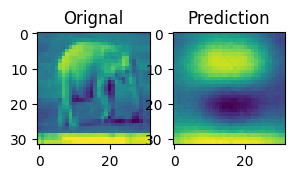

-----------------------Auto Encoder 2------------------------
Epoch=1, Train Loss=0.0228, Eval Loss=0.0188
Epoch=2, Train Loss=0.0164, Eval Loss=0.0143
Epoch=3, Train Loss=0.0132, Eval Loss=0.012
Epoch=4, Train Loss=0.0111, Eval Loss=0.01
Epoch=5, Train Loss=0.0093, Eval Loss=0.0083
Epoch=6, Train Loss=0.0077, Eval Loss=0.0068
Epoch=7, Train Loss=0.0062, Eval Loss=0.0054
Epoch=8, Train Loss=0.005, Eval Loss=0.0044
Epoch=9, Train Loss=0.0041, Eval Loss=0.0036
Epoch=10, Train Loss=0.0034, Eval Loss=0.0031


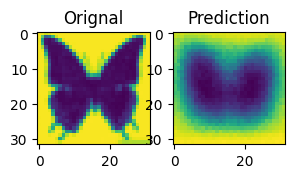

In [74]:
n_epochs=10

print("-----------------------Auto Encoder 1------------------------")
for i in range(n_epochs):
    train_loss=train_e1d1()
    eval_loss,x,pred=eval_e1d1()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(32,32)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(32,32)).cpu())
plt.show()
    
print("-----------------------Auto Encoder 2------------------------")
for i in range(n_epochs):
    print("Epoch=", i+1,", Train Loss=",train_e2d2(),", Eval Loss=",eval_e2d2(),sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(32,32)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(32,32)).cpu())
plt.show()

In [77]:
e1_path = '3encoder1.pth'
d1_path = '3decoder1.pth'
e2_path = '3encoder2.pth'
d2_path = '3decoder2.pth'

torch.save(e1.state_dict(), e1_path)
torch.save(d1.state_dict(), d1_path)
torch.save(e2.state_dict(), e2_path)
torch.save(d2.state_dict(), d2_path)